In [17]:
# z5484442
# Hongyin Zhou
# COMP9414 Assignment 2 – Reinforcement Learning

In [18]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Assuming env.py is in the same directory or properly added to path
from env import GridWorldEnv

## GridWorld Environment

1.  **Agent's Position:** The agent can be in any of the 11 rows and any of the 11 columns.
    *   Number of possible positions: 11 (rows) * 11 (columns) = 121 possible positions.

2.  **Other Environment Factors:** In the provided `GridWorldEnv`, the goal position is fixed at (10, 10), and the obstacle positions are fixed. The starting position is randomly chosen from the available non-obstacle, non-goal cells at the beginning of each episode, but this does not add to the *state space* per step as it's an initial condition. The environment state at any step is solely defined by the agent's current position.

Therefore, the primary component defining the state at any given time step is the agent's position.

The total number of states is primarily determined by the agent's position:
121 (agent positions) = 121 states.

In [19]:
# --- Setup ---
# Hyperparameters (Choose values within ranges, use consistently)
ALPHA = 0.3          # Learning rate (α) - within 0.1 to 0.5
GAMMA = 0.95         # Discount factor (γ) - within 0.9 to 0.99
EPSILON_START = 0.95  # Initial exploration rate - within 0.8 to 1.0
EPSILON_END = 0.05   # Final exploration rate - within 0.01 to 0.1
EPSILON_DECAY = 0.95 # Decay rate (for exponential decay) - close to 1 for gradual decay

# Training parameters
NUM_EPISODES = 500 # Total number of episodes for training
MAX_STEPS_PER_EPISODE = 100 # Maximum steps per episode (to prevent infinite loops if goal unreachable)
GRID_SIZE = 11 # Size of the grid world
NUM_ACTIONS = 4 # Number of actions (Up, Down, Left, Right)
MOVING_AVERAGE_WINDOW = 50 # Window for calculating moving average

# Initialize environment
env = GridWorldEnv() # Use default seed or set a specific one for reproducibility

## Task 1: Q-learning Implementation

* Q-learning equation:

\begin{equation}
Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t)+\alpha[r_{t+1}+\gamma\max_{a \in A(s_{t+1})} Q(s_{t+1},a)]
\end{equation}

In [20]:
visit_counts = np.zeros((GRID_SIZE, GRID_SIZE))  # Track state visitation counts

# --- Epsilon-Greedy Action Selection ---
def epsilon_greedy(state, q_table, base_epsilon):
    """
    Selects an action using epsilon-greedy policy with visit-count-based epsilon adjustment.
    
    Args:
        state (tuple): Current state (x, y) coordinates.
        q_table (numpy.ndarray): Q-table of shape (grid_size, grid_size, num_actions).
        base_epsilon (float): Base exploration rate (0.0 to 1.0).
    
    Returns:
        int: Selected action (0 to NUM_ACTIONS-1).
    
    Notes:
        - Epsilon is adjusted inversely proportional to state visitation counts.
        - Handles ties in Q-values by randomly selecting among the best actions.
        - Includes input validation for robustness.
    """
    # --- Update Visit Counts ---
    visit_counts[state[0], state[1]] += 1

    # --- Calculate State-specific Epsilon ---
    # Epsilon decreases with more visits to encourage exploitation in familiar states
    epsilon = base_epsilon / (1 + visit_counts[state[0], state[1]] / 100)

    # --- Action Selection ---
    if np.random.rand() < epsilon:
        # Explore: Choose a random action
        return np.random.randint(NUM_ACTIONS)
    else:
        # Exploit: Choose action with highest Q-value
        q_values = q_table[state[0], state[1], :]
        max_q = np.max(q_values)
        best_actions = np.where(q_values == max_q)[0]  # Handle ties
        return np.random.choice(best_actions)

In [21]:
# --- 1. Initialize Q-table ---
# Q-table dimensions: (grid_size, grid_size, num_actions)
q_table_qlearning = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

# --- 2. Training Loop & Metrics Tracking ---
# Lists to store metrics for each episode
episode_rewards = []
episode_steps = []
episode_successes = [] # 1 if successful, 0 otherwise

epsilon = EPSILON_START # Start with initial epsilon

for episode in range(NUM_EPISODES):
    # Reset environment and get initial state
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    # --- Episode Loop ---
    while not done and steps < MAX_STEPS_PER_EPISODE:
        # Select action using epsilon-greedy policy
        action = epsilon_greedy(state, q_table_qlearning, epsilon)

        # Take action and observe next state, reward, done
        next_state, reward, done, _ = env.step(action)

        # --- Q-learning Update Rule ---
        # Q(s_t, a_t) <- Q(s_t, a_t) + alpha * [r_{t+1} + gamma * max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
        old_q_value = q_table_qlearning[state[0], state[1], action]
        next_max_q = np.max(q_table_qlearning[next_state[0], next_state[1], :]) # max_a Q(s_{t+1}, a)
        # If the episode is done, there is no next state, so next_max_q should be 0
        if done:
             next_max_q = 0
        temporal_difference = reward + (GAMMA * next_max_q) - old_q_value
        new_q_value = old_q_value + (ALPHA * temporal_difference)
        q_table_qlearning[state[0], state[1], action] = new_q_value

        # Update state, reward, steps
        state = next_state
        total_reward += reward
        steps += 1

    # --- End of Episode ---
    # Record metrics
    episode_rewards.append(total_reward)
    episode_steps.append(steps)
    # Success is defined as reaching the goal (done=True)
    episode_successes.append(1 if done else 0)

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)


--- Task 1: Q-learning Results ---
Average Reward per Episode: 2.36
Success Rate (%): 93.60%
Average Learning Speed (Steps per Episode): 20.31


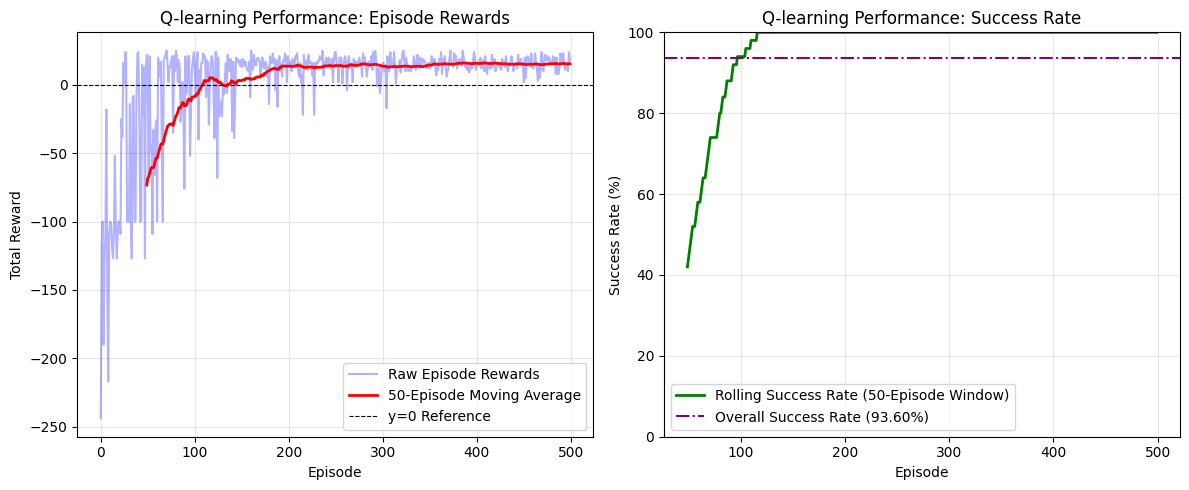

Q-table for Q-learning (Task 1) saved as 'q_table_qlearning_task1.npy'


In [22]:
# --- 3. Calculate Final Metrics (Equations 1, 2, 3) ---
# Equation 2: Average Reward per Episode = Total Sum of Rewards / Number of Episodes
avg_reward_per_episode = np.mean(episode_rewards)

# Equation 1: Success Rate = (Number of Successful Episodes / Total Episodes) * 100
success_rate = (np.sum(episode_successes) / NUM_EPISODES) * 100

# Equation 3: Average Learning Speed (Steps) = Total Steps Taken / Number of Episodes
avg_learning_speed = np.mean(episode_steps)

print("--- Task 1: Q-learning Results ---")
print(f"Average Reward per Episode: {avg_reward_per_episode:.2f}")
print(f"Success Rate (%): {success_rate:.2f}%")
print(f"Average Learning Speed (Steps per Episode): {avg_learning_speed:.2f}")

# --- 4. Generate Performance Plot (Figure 2 style) ---
plt.figure(figsize=(12, 5))

# Subplot 1: Episode Rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, alpha=0.3, label='Raw Episode Rewards', color='blue') # Raw rewards with transparency
# Calculate moving average
moving_avg_rewards = np.convolve(episode_rewards, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_rewards)), moving_avg_rewards, label=f'{MOVING_AVERAGE_WINDOW}-Episode Moving Average', color='red', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='y=0 Reference')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Performance: Episode Rewards')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Success Rate (Rolling)
plt.subplot(1, 2, 2)
# Calculate rolling success rate (e.g., 50-episode window)
rolling_success_rate = np.convolve(episode_successes, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid') * 100
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_successes)), rolling_success_rate, label=f'Rolling Success Rate ({MOVING_AVERAGE_WINDOW}-Episode Window)', color='green', linewidth=2)
plt.axhline(y=success_rate, color='purple', linestyle='-.', linewidth=1.5, label=f'Overall Success Rate ({success_rate:.2f}%)')
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.title('Q-learning Performance: Success Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100) # Success rate is a percentage

plt.tight_layout()
plt.show()

# --- 5. Save Q-table & Episode Rewards ---
np.save('q_table_qlearning_task1.npy', q_table_qlearning)
np.save('task1_episode_rewards_qlearning.npy', episode_rewards)
print("Q-table for Q-learning (Task 1) saved as 'q_table_qlearning_task1.npy'")


## Task 2: SARSA Implementation

* SARSA equation:

\begin{equation}
Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t)+\alpha[r_{t+1}+\gamma Q(s_{t+1},a_{t+1})]
\end{equation}

In [23]:
# --- 1. Initialize Q-table for SARSA ---
q_table_sarsa = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

# --- 2. Training Loop & Metrics Tracking ---
# Lists to store metrics for each episode
episode_rewards_sarsa = []
episode_steps_sarsa = []
episode_successes_sarsa = []

epiilon = EPSILON_START # Start with initial epsilon for SARSA

for episode in range(NUM_EPISODES):
    # Reset environment and get initial state
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    # --- Crucial: Select the FIRST action for the initial state ---
    action = epsilon_greedy(state, q_table_sarsa, epsilon)

    # --- Episode Loop ---
    while not done and steps < MAX_STEPS_PER_EPISODE:
        # Take action and observe next state, reward, done
        next_state, reward, done, _ = env.step(action)

        # --- Crucial: Select the NEXT action for the NEXT state BEFORE update ---
        next_action = epsilon_greedy(next_state, q_table_sarsa, epsilon)

        # --- SARSA Update Rule ---
        # Q(s_t, a_t) <- Q(s_t, a_t) + alpha * [r_{t+1} + gamma * Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
        old_q_value = q_table_sarsa[state[0], state[1], action]
        # Get Q-value for the next state-action pair
        next_q_value = q_table_sarsa[next_state[0], next_state[1], next_action]
        # If the episode is done, there is no next state/action, so next_q_value should be 0
        if done:
            next_q_value = 0
        temporal_difference = reward + (GAMMA * next_q_value) - old_q_value
        new_q_value = old_q_value + (ALPHA * temporal_difference)
        q_table_sarsa[state[0], state[1], action] = new_q_value

        # Update state and action for the next iteration
        state = next_state
        action = next_action # This is the key difference from Q-learning

        # Update metrics
        total_reward += reward
        steps += 1

    # --- End of Episode ---
    episode_rewards_sarsa.append(total_reward)
    episode_steps_sarsa.append(steps)
    episode_successes_sarsa.append(1 if done else 0)

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)



--- Task 2: SARSA Results ---
Average Reward per Episode: 4.76
Success Rate (%): 94.80%
Average Learning Speed (Steps per Episode): 18.77


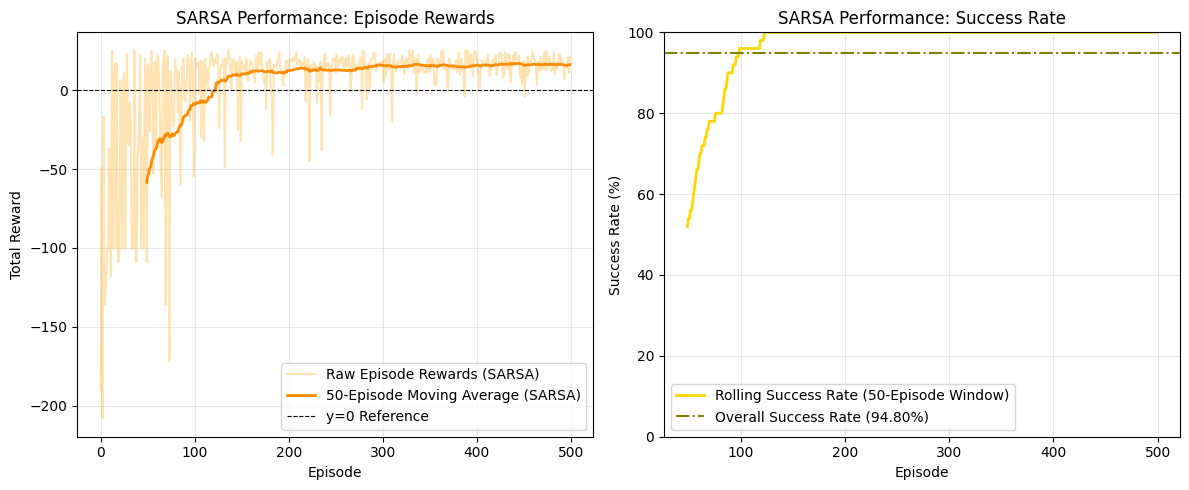

Q-table for SARSA (Task 2) saved as 'q_table_sarsa_task2.npy'


In [24]:
# --- 3. Calculate Final Metrics (Equations 1, 2, 3) ---
avg_reward_per_episode_sarsa = np.mean(episode_rewards_sarsa)
success_rate_sarsa = (np.sum(episode_successes_sarsa) / NUM_EPISODES) * 100
avg_learning_speed_sarsa = np.mean(episode_steps_sarsa)

print("\n--- Task 2: SARSA Results ---")
print(f"Average Reward per Episode: {avg_reward_per_episode_sarsa:.2f}")
print(f"Success Rate (%): {success_rate_sarsa:.2f}%")
print(f"Average Learning Speed (Steps per Episode): {avg_learning_speed_sarsa:.2f}")

# --- 4. Generate Performance Plot (Figure 3 style) ---
plt.figure(figsize=(12, 5))

# Subplot 1: Episode Rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards_sarsa, alpha=0.3, label='Raw Episode Rewards (SARSA)', color='orange')
moving_avg_rewards_sarsa = np.convolve(episode_rewards_sarsa, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_rewards_sarsa)), moving_avg_rewards_sarsa, label=f'{MOVING_AVERAGE_WINDOW}-Episode Moving Average (SARSA)', color='darkorange', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='y=0 Reference')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('SARSA Performance: Episode Rewards')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Success Rate (Rolling)
plt.subplot(1, 2, 2)
rolling_success_rate_sarsa = np.convolve(episode_successes_sarsa, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid') * 100
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_successes_sarsa)), rolling_success_rate_sarsa, label=f'Rolling Success Rate ({MOVING_AVERAGE_WINDOW}-Episode Window)', color='gold', linewidth=2)
plt.axhline(y=success_rate_sarsa, color='olive', linestyle='-.', linewidth=1.5, label=f'Overall Success Rate ({success_rate_sarsa:.2f}%)')
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.title('SARSA Performance: Success Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# --- 5. Save Q-table & Episode Rewards ---
np.save('q_table_sarsa_task2.npy', q_table_sarsa)
np.save('task2_episode_rewards_sarsa.npy', episode_rewards_sarsa)
print("Q-table for SARSA (Task 2) saved as 'q_table_sarsa_task2.npy'")


## Baseline Comparison (Q-Learning vs SARSA Learning)


--- Baseline Comparison: Q-learning vs SARSA ---


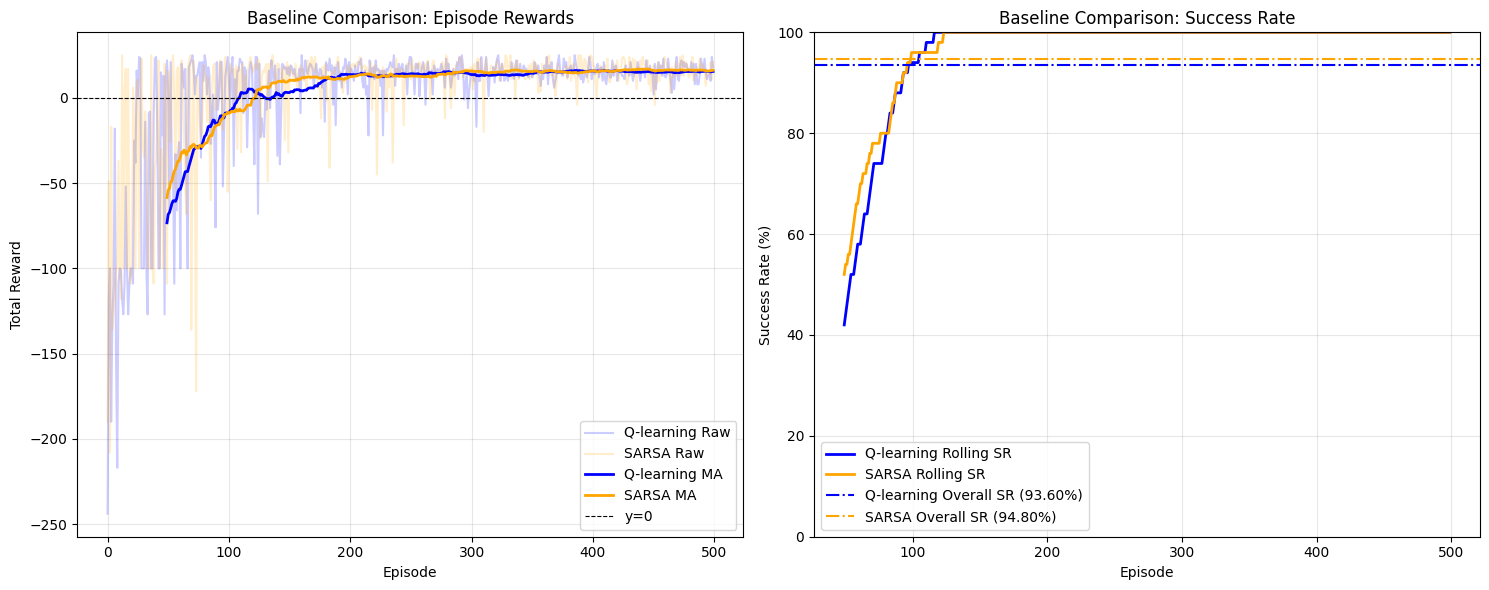

Numerical Summary:
  Q-learning - Avg Reward: 2.36, Success Rate: 93.60%, Avg Steps: 20.31
  SARSA      - Avg Reward: 4.76, Success Rate: 94.80%, Avg Steps: 18.77


In [25]:
# --- Baseline Comparison (Task 1 vs Task 2) ---
print("\n--- Baseline Comparison: Q-learning vs SARSA ---")

# Re-calculate moving averages for comparison using the same window
moving_avg_rewards_ql = np.convolve(episode_rewards, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
moving_avg_rewards_sa = np.convolve(episode_rewards_sarsa, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
rolling_sr_ql = np.convolve(episode_successes, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid') * 100
rolling_sr_sa = np.convolve(episode_successes_sarsa, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid') * 100

plt.figure(figsize=(15, 6))

# --- Plot 1: Episode Rewards Comparison ---
plt.subplot(1, 2, 1)
# Raw Rewards
plt.plot(episode_rewards, alpha=0.2, label='Q-learning Raw', color='blue')
plt.plot(episode_rewards_sarsa, alpha=0.2, label='SARSA Raw', color='orange')
# Moving Averages
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_rewards)), moving_avg_rewards_ql, label='Q-learning MA', color='blue', linewidth=2)
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_rewards_sarsa)), moving_avg_rewards_sa, label='SARSA MA', color='orange', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='y=0')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Baseline Comparison: Episode Rewards')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Success Rate Comparison ---
plt.subplot(1, 2, 2)
# Rolling Success Rates
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_successes)), rolling_sr_ql, label='Q-learning Rolling SR', color='blue', linewidth=2)
plt.plot(range(MOVING_AVERAGE_WINDOW - 1, len(episode_successes_sarsa)), rolling_sr_sa, label='SARSA Rolling SR', color='orange', linewidth=2)
# Overall Success Rates
plt.axhline(y=success_rate, color='blue', linestyle='-.', linewidth=1.5, label=f'Q-learning Overall SR ({success_rate:.2f}%)')
plt.axhline(y=success_rate_sarsa, color='orange', linestyle='-.', linewidth=1.5, label=f'SARSA Overall SR ({success_rate_sarsa:.2f}%)')
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.title('Baseline Comparison: Success Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("Numerical Summary:")
print(f"  Q-learning - Avg Reward: {avg_reward_per_episode:.2f}, Success Rate: {success_rate:.2f}%, Avg Steps: {avg_learning_speed:.2f}")
print(f"  SARSA      - Avg Reward: {avg_reward_per_episode_sarsa:.2f}, Success Rate: {success_rate_sarsa:.2f}%, Avg Steps: {avg_learning_speed_sarsa:.2f}")


## Task 3: Q-learning with Teacher (Q-learning student)

In [26]:
# --- Define Teacher Advice Function ---
def get_teacher_advice(teacher_q_table, state, accuracy, availability, tau_min=0.1, tau_max=10.0):
    """
    Retrieves the teacher's advised action based on the teacher's Q-table, accuracy, and availability.
    
    Args:
        teacher_q_table (numpy.ndarray): Teacher's Q-table, shape (grid_size, grid_size, num_actions).
        state (tuple): Current state (x, y).
        accuracy (float): Probability of correct advice (0.0 to 1.0).
        availability (float): Probability of teacher providing advice (0.0 to 1.0).
        tau_min (float): Minimum temperature parameter tau, default 0.1.
        tau_max (float): Maximum temperature parameter tau, default 10.0.
    
    Returns:
        int or None: Advised action (0 to num_actions-1) if teacher provides advice; None otherwise.
    
    Notes:
        - Uses softmax action selection with temperature tau to model accuracy.
        - Lower accuracy increases tau, making advice more random and less reliable.
        - Higher availability with low accuracy leads to poorer performance; high accuracy with high availability improves performance.
    """
    # --- Check Availability ---
    # Decide whether the teacher provides advice based on availability
    if np.random.random() < availability:
        # --- Extract Q-values ---
        # Get Q-values for the current state
        q_values = teacher_q_table[state[0], state[1], :]
        
        # --- Calculate Temperature Parameter ---
        # Compute tau based on accuracy: lower accuracy -> higher tau (more random)
        tau = tau_min + (tau_max - tau_min) * (1 - accuracy)
        
        # --- Compute Softmax Probabilities ---
        # Calculate action probabilities using softmax
        exp_q = np.exp(q_values / tau)
        probabilities = exp_q / np.sum(exp_q)
        
        # --- Select Action ---
        # Choose action based on probabilities
        action = np.random.choice(len(q_values), p=probabilities)
        return action
    else:
        # --- No Advice ---
        # Return None if teacher is not available
        return None


--- Task 3: Q-learning with Teacher (Q-learning student) ---
Teacher Q-table (Q-learning) loaded successfully.
  Running experiment: Availability=0.1, Accuracy=0.1
  -> Average Reward: 3.08
  Running experiment: Availability=0.1, Accuracy=0.3
  -> Average Reward: 3.90
  Running experiment: Availability=0.1, Accuracy=0.5
  -> Average Reward: 4.69
  Running experiment: Availability=0.1, Accuracy=0.7
  -> Average Reward: 3.51
  Running experiment: Availability=0.1, Accuracy=1.0
  -> Average Reward: 3.52
  Running experiment: Availability=0.3, Accuracy=0.1
  -> Average Reward: 0.12
  Running experiment: Availability=0.3, Accuracy=0.3
  -> Average Reward: 1.47
  Running experiment: Availability=0.3, Accuracy=0.5
  -> Average Reward: 1.75
  Running experiment: Availability=0.3, Accuracy=0.7
  -> Average Reward: 2.10
  Running experiment: Availability=0.3, Accuracy=1.0
  -> Average Reward: 2.48
  Running experiment: Availability=0.5, Accuracy=0.1
  -> Average Reward: -3.29
  Running experime

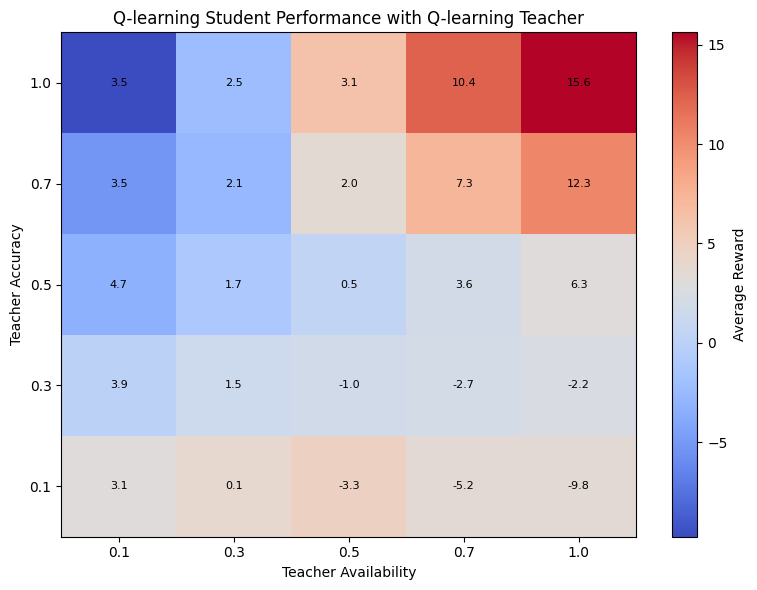

Task 3 (Q-learning with Teacher) completed and heatmap displayed.


In [27]:
print("\n--- Task 3: Q-learning with Teacher (Q-learning student) ---")

# For demonstration, let's use fewer episodes for teacher experiments
NUM_EPISODES_TEACHER = 500

# --- 1. Load Teacher Q-table ---
try:
    teacher_q_table = np.load('q_table_qlearning_task1.npy')
    print("Teacher Q-table (Q-learning) loaded successfully.")
except FileNotFoundError:
    print("Error: Teacher Q-table 'q_table_qlearning_task1.npy' not found. Please run Task 1 first.")
    # raise # Or handle appropriately

# --- 2. Define Parameter Grid ---
availability_values = [0.1, 0.3, 0.5, 0.7, 1.0]
accuracy_values = [0.1, 0.3, 0.5, 0.7, 1.0]

# --- 3. Storage for Results ---
# Dictionary to store average rewards for each (availability, accuracy) pair
results_heatmap_q = {} # Key: (availability, accuracy), Value: average_reward

# --- 4. Nested Loop for Experiments ---
for availability in availability_values:
    for accuracy in accuracy_values:
        print(f"  Running experiment: Availability={availability}, Accuracy={accuracy}")

        # Initialize Student Q-table
        student_q_table = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

        epsilon = EPSILON_START # Start with initial epsilon for each configuration

        # --- Training Loop for this specific (availability, accuracy) ---
        # Lists to store metrics for this run
        run_episode_rewards = []
        run_episode_steps = []
        run_episode_successes = []

        for episode in range(NUM_EPISODES_TEACHER):
            state = env.reset()
            total_reward = 0
            steps = 0
            done = False

            while not done and steps < MAX_STEPS_PER_EPISODE:
                # Student selects action based on its own policy
                student_action = epsilon_greedy(state, student_q_table, epsilon)

                # --- Teacher Intervention ---
                final_action = student_action # Default to student's action
                if np.random.rand() < availability:
                    # Teacher provides advice
                    advised_action = get_teacher_advice(teacher_q_table, state, accuracy, availability)
                    final_action = advised_action # Override student's action

                # Take the final action (student's or teacher's/advised)
                next_state, reward, done, _ = env.step(final_action)

                # --- Student Q-learning Update (based on final_action taken) ---
                old_q_value = student_q_table[state[0], state[1], final_action]
                next_max_q = np.max(student_q_table[next_state[0], next_state[1], :])
                if done:
                    next_max_q = 0
                td = reward + (GAMMA * next_max_q) - old_q_value
                new_q_value = old_q_value + (ALPHA * td)
                student_q_table[state[0], state[1], final_action] = new_q_value

                # Update state
                state = next_state
                total_reward += reward
                steps += 1

            # End of episode for this run
            run_episode_rewards.append(total_reward)
            run_episode_steps.append(steps)
            run_episode_successes.append(1 if done else 0)
            
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # --- Calculate Average Metrics for this (availability, accuracy) ---
        avg_reward_this_config = np.mean(run_episode_rewards)
        success_rate_this_config = (np.sum(run_episode_successes) / NUM_EPISODES_TEACHER) * 100
        avg_steps_this_config = np.mean(run_episode_steps)

        # Store the average reward for heatmap AND the full reward sequence for analysis
        results_heatmap_q[(availability, accuracy)] = {
            'avg_reward': avg_reward_this_config,
            'rewards': run_episode_rewards # This is the list of rewards for each episode
        }
        print(f"  -> Average Reward: {avg_reward_this_config:.2f}") # Optional: print result

# --- 5. Generate Heatmap (Figure 6 style) ---
# Prepare data for heatmap
# Create 2D arrays for plotting
av_grid, ac_grid = np.meshgrid(availability_values, accuracy_values, indexing='ij') # Create coordinate matrices
rewards_grid = np.zeros_like(av_grid, dtype=float)

for i, av in enumerate(availability_values):
    for j, ac in enumerate(accuracy_values):
        # Retrieve the dictionary for this (availability, accuracy) pair
        result_dict = results_heatmap_q.get((av, ac), None)
        if result_dict is not None:
            # Extract the average reward from the dictionary
            rewards_grid[i, j] = result_dict['avg_reward']
        else:
            # If no data, set to NaN for the heatmap
            rewards_grid[i, j] = np.nan

# Plotting the heatmap
plt.figure(figsize=(8, 6))
# Use imshow or pcolormesh. imshow is simpler for regular grids.
im = plt.imshow(rewards_grid, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(im, label='Average Reward')
# Set ticks and labels
plt.xticks(ticks=np.arange(len(availability_values)), labels=availability_values)
plt.yticks(ticks=np.arange(len(accuracy_values)), labels=accuracy_values)
plt.xlabel('Teacher Availability')
plt.ylabel('Teacher Accuracy')
plt.title('Q-learning Student Performance with Q-learning Teacher')

# Optional: Add text annotations for values
for i in range(len(availability_values)):
    for j in range(len(accuracy_values)):
        text = plt.text(j, i, f'{rewards_grid[j, i]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

# Save results for analysis
np.save('task3_results_qlearning_with_rewards.npy', results_heatmap_q)
print("Task 3 (Q-learning with Teacher) completed and heatmap displayed.")


## Task 4: SARSA with Teacher (SARSA student)


--- Task 4: SARSA with Teacher (SARSA student) ---
Teacher Q-table (SARSA) loaded successfully.
  Running experiment: Availability=0.1, Accuracy=0.1
  -> Average Reward: 2.01
  Running experiment: Availability=0.1, Accuracy=0.3
  -> Average Reward: 3.42
  Running experiment: Availability=0.1, Accuracy=0.5
  -> Average Reward: 3.38
  Running experiment: Availability=0.1, Accuracy=0.7
  -> Average Reward: 2.76
  Running experiment: Availability=0.1, Accuracy=1.0
  -> Average Reward: 2.60
  Running experiment: Availability=0.3, Accuracy=0.1
  -> Average Reward: -0.96
  Running experiment: Availability=0.3, Accuracy=0.3
  -> Average Reward: -2.62
  Running experiment: Availability=0.3, Accuracy=0.5
  -> Average Reward: 0.21
  Running experiment: Availability=0.3, Accuracy=0.7
  -> Average Reward: 1.52
  Running experiment: Availability=0.3, Accuracy=1.0
  -> Average Reward: 1.85
  Running experiment: Availability=0.5, Accuracy=0.1
  -> Average Reward: -3.18
  Running experiment: Availabil

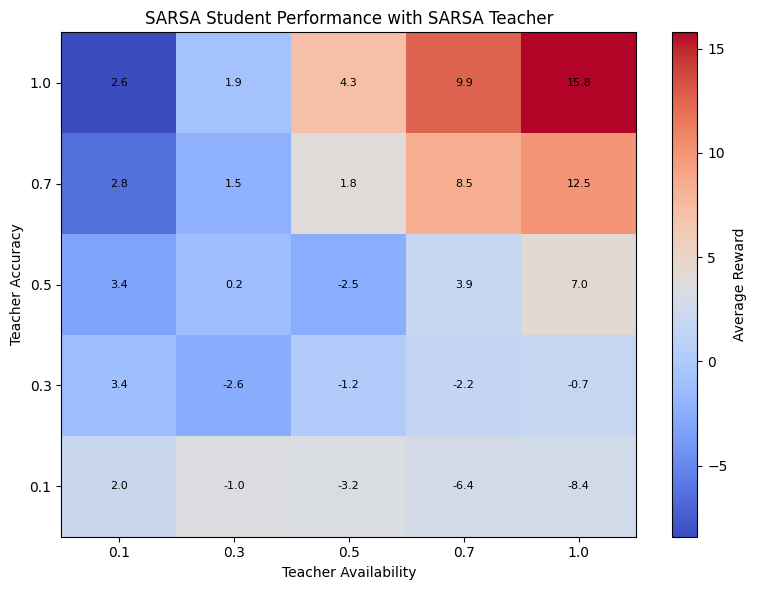

Task 4 (SARSA with Teacher) completed and heatmap displayed.


In [28]:
print("\n--- Task 4: SARSA with Teacher (SARSA student) ---")

# --- 1. Load Teacher Q-table ---
try:
    teacher_q_table_sarsa = np.load('q_table_sarsa_task2.npy')
    print("Teacher Q-table (SARSA) loaded successfully.")
except FileNotFoundError:
    print("Error: Teacher Q-table 'q_table_sarsa_task2.npy' not found. Please run Task 2 first.")
    # raise

# --- 2. Storage for Results ---
results_heatmap_s = {} # Key: (availability, accuracy), Value: average_reward

# --- 3. Nested Loop for Experiments ---
for availability in availability_values:
    for accuracy in accuracy_values:
        print(f"  Running experiment: Availability={availability}, Accuracy={accuracy}")

        # Initialize Student Q-table
        student_q_table_sarsa = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

        epsilon = EPSILON_START # Start with initial epsilon for each configuration

        # --- Training Loop for this specific (availability, accuracy) ---
        run_episode_rewards_s = []
        run_episode_steps_s = []
        run_episode_successes_s = []

        for episode in range(NUM_EPISODES_TEACHER):
            state = env.reset()
            total_reward = 0
            steps = 0
            done = False

            # --- Crucial: Select FIRST action for initial state ---
            action = epsilon_greedy(state, student_q_table_sarsa, epsilon)

            while not done and steps < MAX_STEPS_PER_EPISODE:
                # --- Teacher Intervention (same as Task 3) ---
                final_action = action # Default to student's action
                if np.random.rand() < availability:
                    advised_action = get_teacher_advice(teacher_q_table, state, accuracy, availability)
                    final_action = advised_action # Override

                # Take the final action
                next_state, reward, done, _ = env.step(final_action)

                # --- Crucial: Select NEXT action for NEXT state BEFORE update ---
                next_action = epsilon_greedy(next_state, student_q_table_sarsa, epsilon)

                # --- Student SARSA Update (based on final_action taken and next_action selected) ---
                old_q_value = student_q_table_sarsa[state[0], state[1], final_action]
                next_q_value = student_q_table_sarsa[next_state[0], next_state[1], next_action]
                if done:
                    next_q_value = 0
                td = reward + (GAMMA * next_q_value) - old_q_value
                new_q_value = old_q_value + (ALPHA * td)
                student_q_table_sarsa[state[0], state[1], final_action] = new_q_value

                # Update state and action for next iteration
                state = next_state
                action = next_action # Key difference from Q-learning

                total_reward += reward
                steps += 1

            # End of episode for this run
            run_episode_rewards_s.append(total_reward)
            run_episode_steps_s.append(steps)
            run_episode_successes_s.append(1 if done else 0)

            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        # --- Calculate Average Metrics for this (availability, accuracy) ---
        avg_reward_this_config_s = np.mean(run_episode_rewards_s)
        # --- Calculate Average Metrics for this (availability, accuracy) ---
        avg_reward_this_config_s = np.mean(run_episode_rewards_s)
        # Store the average reward for heatmap AND the full reward sequence for analysis
        results_heatmap_s[(availability, accuracy)] = {
            'avg_reward': avg_reward_this_config_s,
            'rewards': run_episode_rewards_s # This is the list of rewards for each episode
        }
        print(f"  -> Average Reward: {avg_reward_this_config_s:.2f}")

# --- 4. Generate Heatmap ---
# Prepare data for heatmap
# Prepare data for heatmap using the stored average rewards
rewards_grid_s = np.zeros_like(av_grid, dtype=float)
for i, av in enumerate(availability_values):
    for j, ac in enumerate(accuracy_values):
        # Retrieve the dictionary for this configuration
        result_dict = results_heatmap_s.get((av, ac), None)
        if result_dict is not None:
            # Extract the average reward from the dictionary
            rewards_grid_s[i, j] = result_dict['avg_reward']
        else:
            # If data is missing for some reason, use NaN
            rewards_grid_s[i, j] = np.nan
            print(f"Warning: No data found for SARSA (Avail={av}, Acc={ac}) when generating heatmap.")

plt.figure(figsize=(8, 6))
im_s = plt.imshow(rewards_grid_s, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(im_s, label='Average Reward')
plt.xticks(ticks=np.arange(len(availability_values)), labels=availability_values)
plt.yticks(ticks=np.arange(len(accuracy_values)), labels=accuracy_values)
plt.xlabel('Teacher Availability')
plt.ylabel('Teacher Accuracy')
plt.title('SARSA Student Performance with SARSA Teacher')

# Optional: Add text annotations
for i in range(len(availability_values)):
    for j in range(len(accuracy_values)):
        text = plt.text(j, i, f'{rewards_grid_s[j, i]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

# Save results for analysis
np.save('task4_results_sarsa_with_rewards.npy', results_heatmap_s)
print("Task 4 (SARSA with Teacher) completed and heatmap displayed.")


## * Analysis and Discussion


--- Analysis and Discussion ---
Loaded Q-learning baseline rewards for 500 episodes.
Loaded SARSA baseline rewards for 500 episodes.
Loaded teacher-guided experiment data.


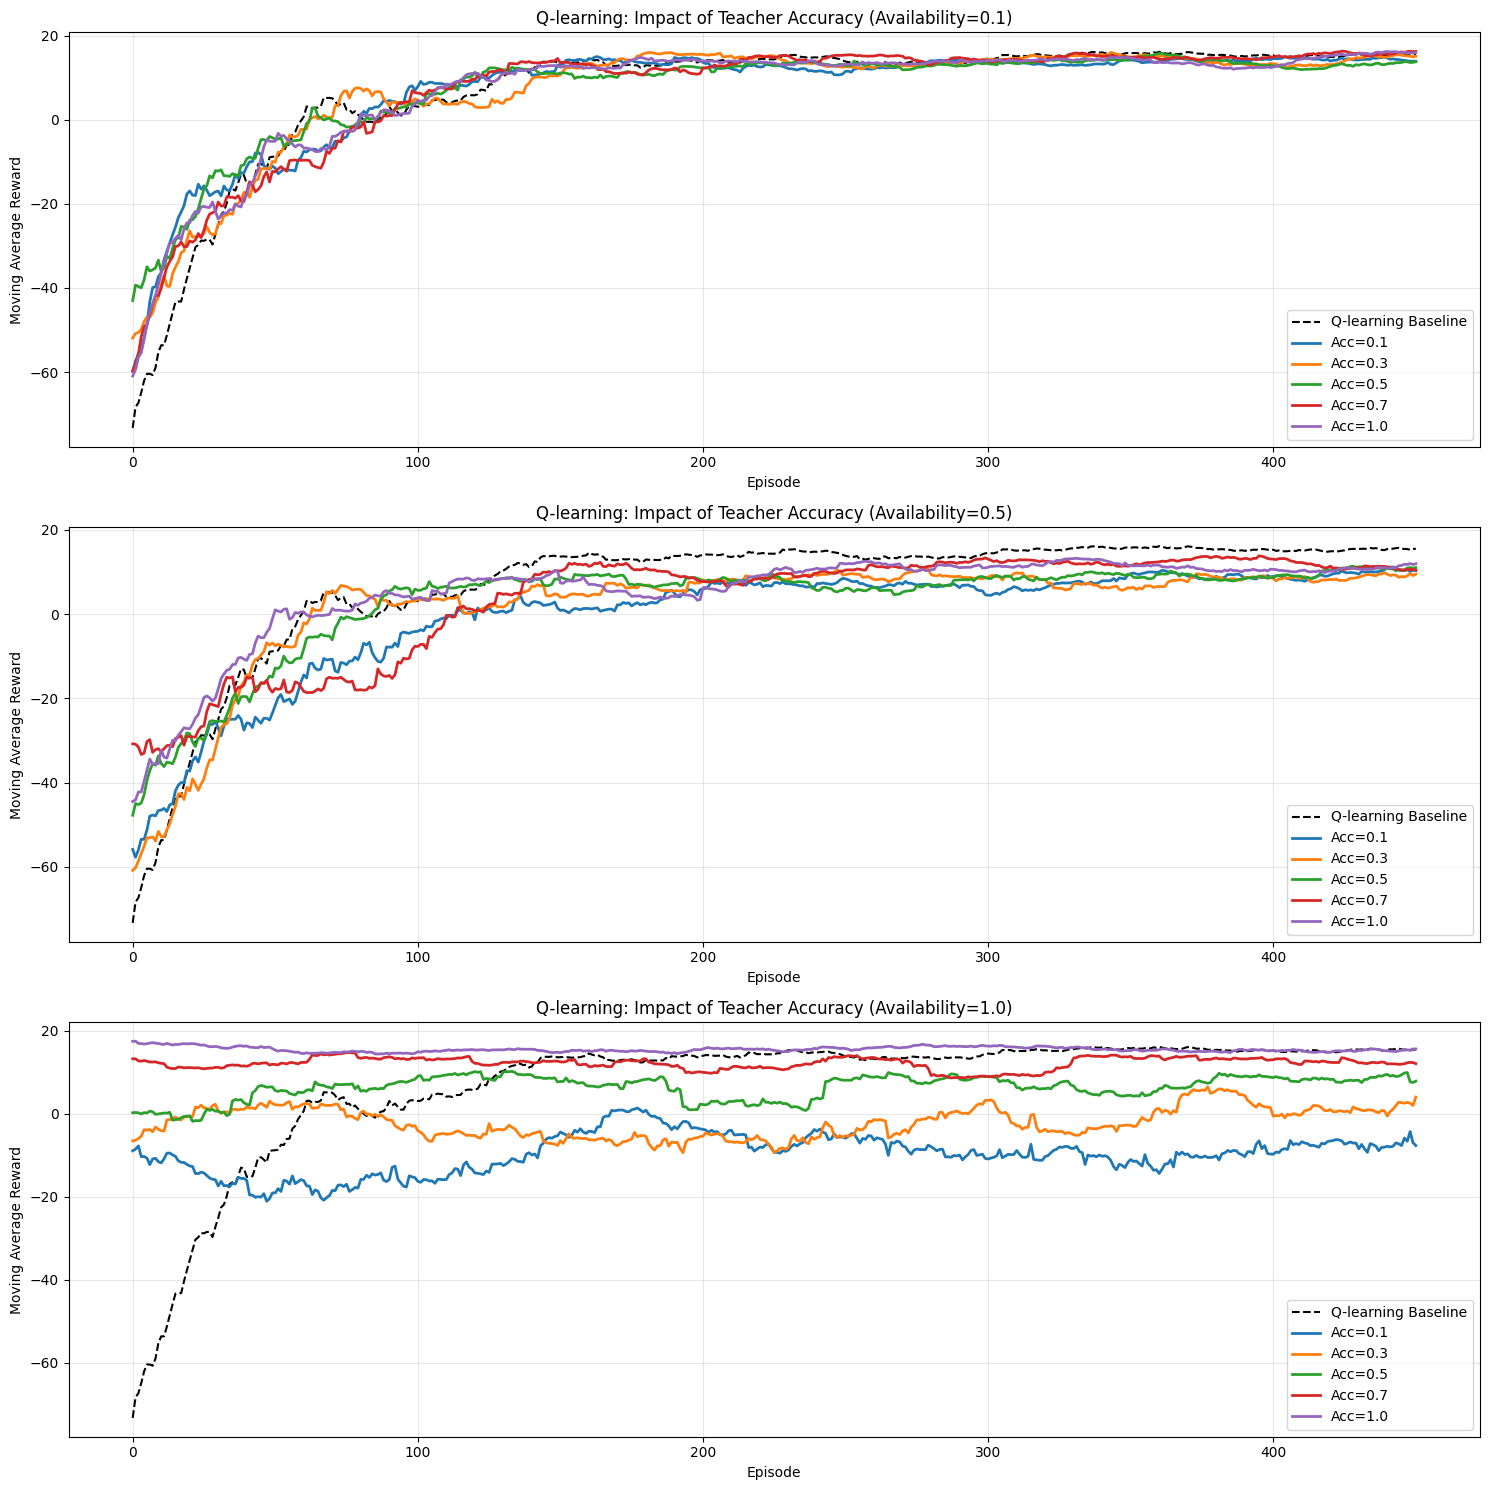

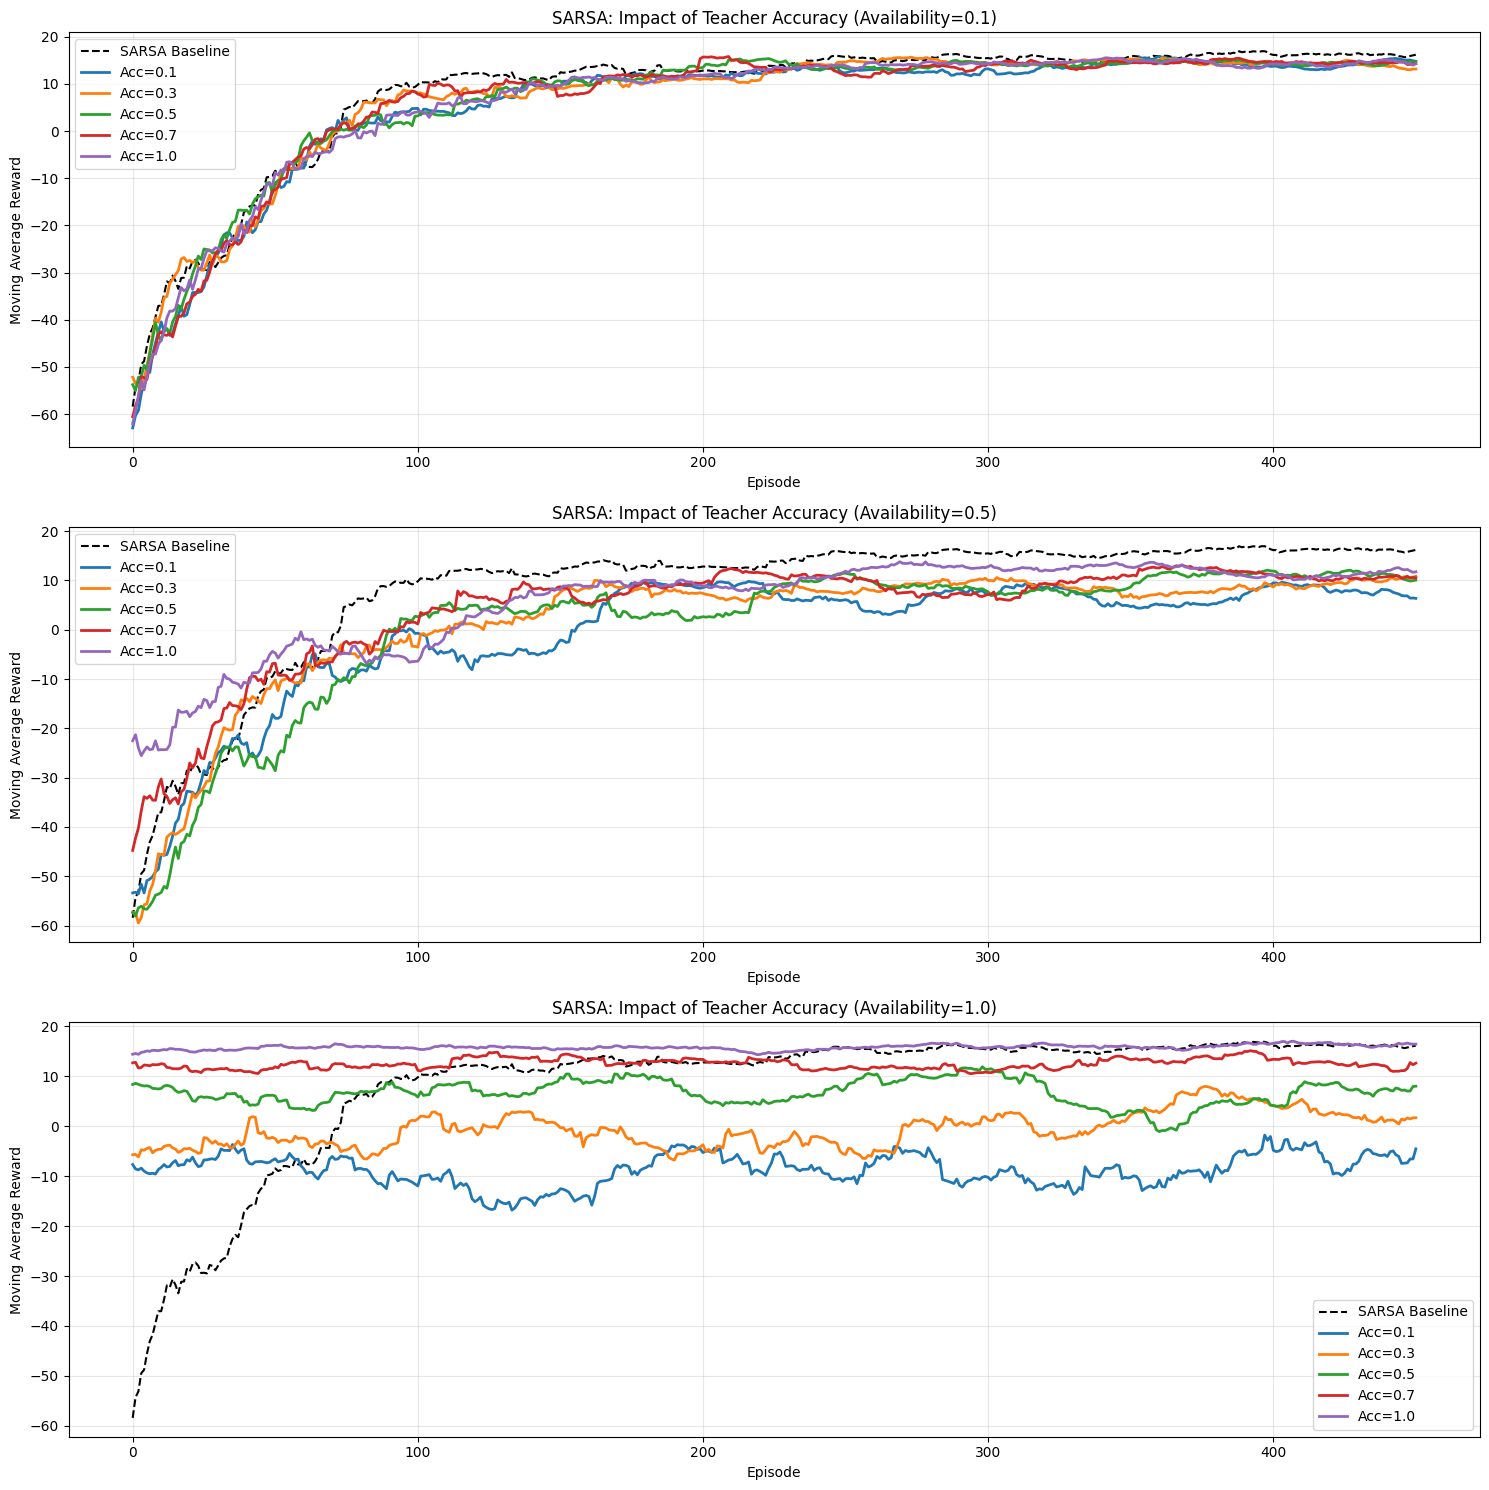

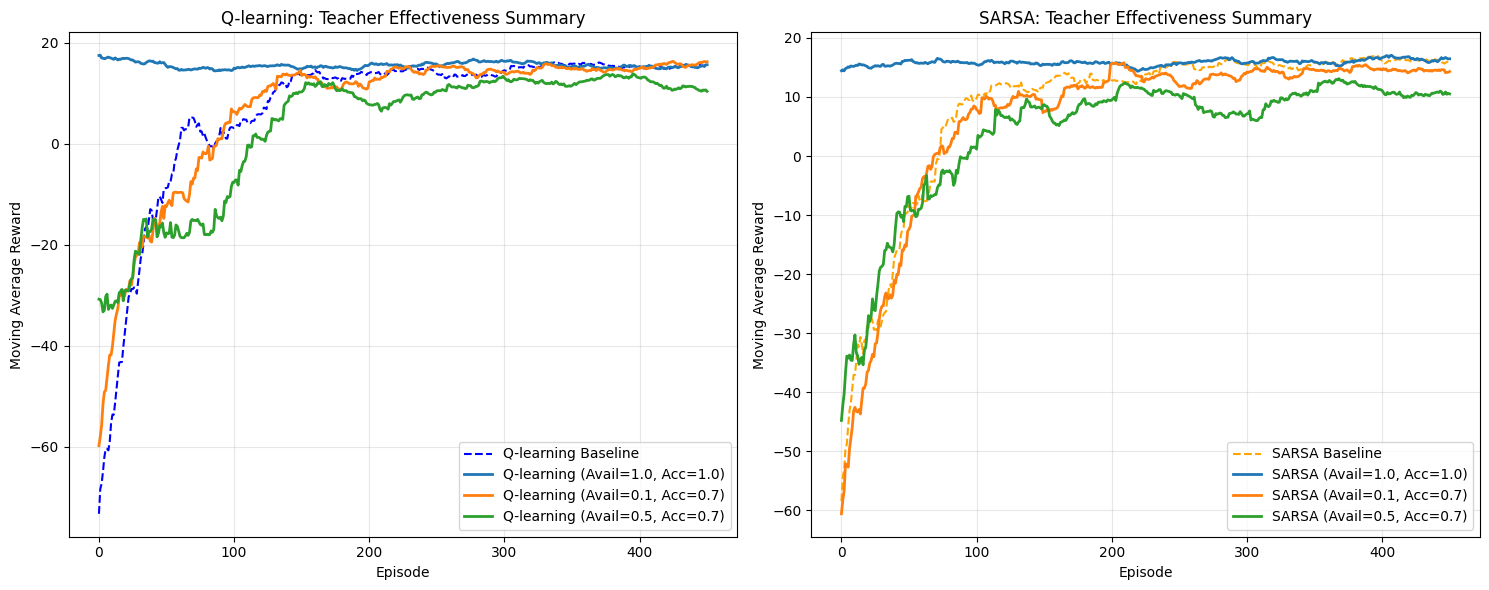


--- Verifying Heatmaps with Loaded Data ---


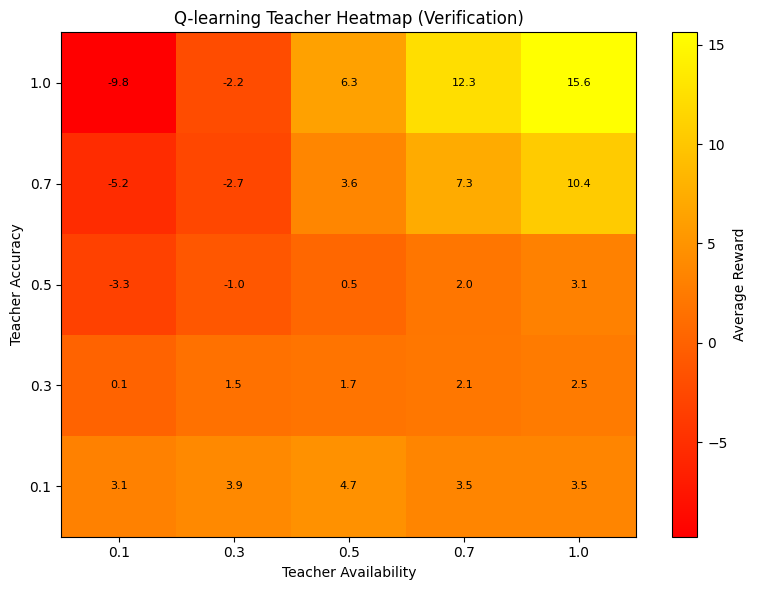

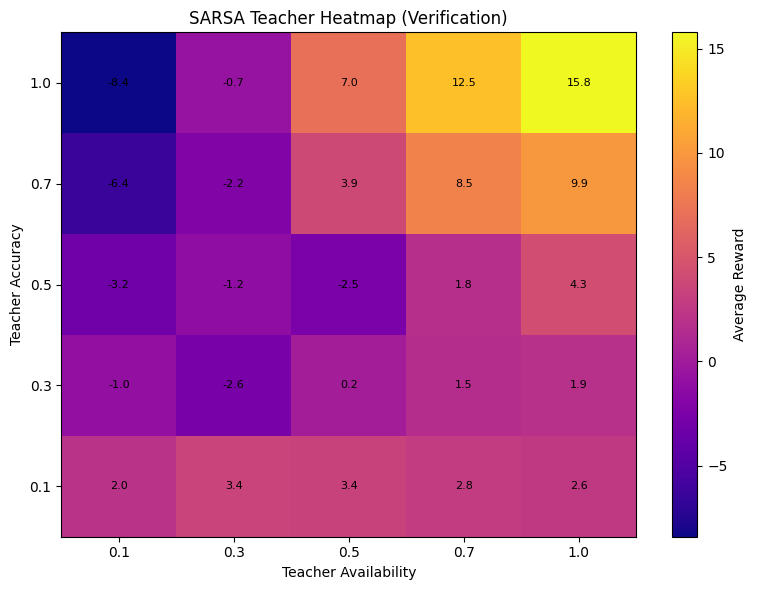


--- Analysis and Discussion Completed ---


In [29]:
print("\n--- Analysis and Discussion ---")

# --- 1. Load Episode Reward Sequences for Baselines ---
try:
    # Load the actual reward sequences from Task 1 and Task 2
    episode_rewards_ql = np.load('task1_episode_rewards_qlearning.npy')
    episode_rewards_sa = np.load('task2_episode_rewards_sarsa.npy')
    NUM_EPISODES_BASELINE_QL = len(episode_rewards_ql)
    NUM_EPISODES_BASELINE_SA = len(episode_rewards_sa)
    print(f"Loaded Q-learning baseline rewards for {NUM_EPISODES_BASELINE_QL} episodes.")
    print(f"Loaded SARSA baseline rewards for {NUM_EPISODES_BASELINE_SA} episodes.")
except FileNotFoundError as e:
    print(f"Error loading baseline reward files: {e}")
    print("Please ensure Task 1 and Task 2 have been run and rewards saved.")
    raise

# --- Load Episode Reward Sequences for Teacher-Guided Experiments ---
try:
    # Load the dictionaries containing full reward sequences from Task 3 and Task 4
    results_teacher_q = np.load('task3_results_qlearning_with_rewards.npy', allow_pickle=True).item()
    results_teacher_s = np.load('task4_results_sarsa_with_rewards.npy', allow_pickle=True).item()
    print("Loaded teacher-guided experiment data.")
except FileNotFoundError as e:
    print(f"Error loading teacher experiment reward files: {e}")
    print("Please ensure Task 3 and Task 4 have been run and rewards saved with sequences.")
    raise

MOVING_AVERAGE_WINDOW = 50 # Use the same window as in Tasks 1 & 2 if you used one there

# --- 2. Calculate Moving Averages for Baselines ---
# Note: np.convolve with 'valid' mode reduces the length of the output
# If your original plotting used the full length, you might need to pad or adjust x-axis
ma_rewards_ql = np.convolve(episode_rewards_ql, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
ma_rewards_sa = np.convolve(episode_rewards_sa, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
x_ma_ql = np.arange(len(ma_rewards_ql))
x_ma_sa = np.arange(len(ma_rewards_sa))

# --- Selected Availabilities and Accuracies for Analysis ---
selected_availabilities = [0.1, 0.5, 1.0] # Example selections as per requirements
selected_accuracies = [0.1, 0.3, 0.5, 0.7, 1.0]
selected_configs_summary = [(1.0, 1.0), (0.1, 0.7), (0.5, 0.7)] # Example for summary

# --- 3. Teacher Impact on Learning Curves (Q-learning) ---
plt.figure(figsize=(15, 5 * len(selected_availabilities)))
for i, avail in enumerate(selected_availabilities):
    plt.subplot(len(selected_availabilities), 1, i + 1)

    # Plot Q-learning baseline moving average
    plt.plot(x_ma_ql, ma_rewards_ql, label='Q-learning Baseline', color='black', linestyle='--')

    # Plot teacher-guided curves for different accuracies
    for acc in selected_accuracies:
        key = (avail, acc)
        if key in results_teacher_q:
            # Retrieve the list of rewards for this specific configuration
            episode_rewards_tq = results_teacher_q[key]['rewards']
            # Calculate moving average for this configuration
            ma_rewards_tq = np.convolve(episode_rewards_tq, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
            x_ma_tq = np.arange(len(ma_rewards_tq))
            plt.plot(x_ma_tq, ma_rewards_tq, label=f'Acc={acc}', linewidth=2)
        else:
            print(f"Warning: No data for Q-learning Teacher (Avail={avail}, Acc={acc})")

    plt.title(f'Q-learning: Impact of Teacher Accuracy (Availability={avail})')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 4. Teacher Impact on Learning Curves (SARSA) ---
plt.figure(figsize=(15, 5 * len(selected_availabilities)))
for i, avail in enumerate(selected_availabilities):
    plt.subplot(len(selected_availabilities), 1, i + 1)

    # Plot SARSA baseline moving average
    plt.plot(x_ma_sa, ma_rewards_sa, label='SARSA Baseline', color='black', linestyle='--')

    # Plot teacher-guided curves for different accuracies
    for acc in selected_accuracies:
        key = (avail, acc)
        if key in results_teacher_s:
            # Retrieve the list of rewards for this specific configuration
            episode_rewards_ts = results_teacher_s[key]['rewards']
            # Calculate moving average for this configuration
            ma_rewards_ts = np.convolve(episode_rewards_ts, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
            x_ma_ts = np.arange(len(ma_rewards_ts))
            plt.plot(x_ma_ts, ma_rewards_ts, label=f'Acc={acc}', linewidth=2)
        else:
            print(f"Warning: No data for SARSA Teacher (Avail={avail}, Acc={acc})")

    plt.title(f'SARSA: Impact of Teacher Accuracy (Availability={avail})')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 5. Teacher Effectiveness Summary ---
plt.figure(figsize=(15, 6))

# --- Plot for Q-learning Summary ---
plt.subplot(1, 2, 1)
# Plot Q-learning baseline moving average
plt.plot(x_ma_ql, ma_rewards_ql, label='Q-learning Baseline', color='blue', linestyle='--')

# Plot selected teacher configurations
for avail, acc in selected_configs_summary:
    key = (avail, acc)
    if key in results_teacher_q:
        episode_rewards_tq_sum = results_teacher_q[key]['rewards']
        ma_rewards_tq_sum = np.convolve(episode_rewards_tq_sum, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
        x_ma_tq_sum = np.arange(len(ma_rewards_tq_sum))
        plt.plot(x_ma_tq_sum, ma_rewards_tq_sum, label=f'Q-learning (Avail={avail}, Acc={acc})', linewidth=2)
    else:
        print(f"Warning: No data for Q-learning Teacher Summary (Avail={avail}, Acc={acc})")

plt.title('Q-learning: Teacher Effectiveness Summary')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot for SARSA Summary ---
plt.subplot(1, 2, 2)
# Plot SARSA baseline moving average
plt.plot(x_ma_sa, ma_rewards_sa, label='SARSA Baseline', color='orange', linestyle='--')

# Plot selected teacher configurations
for avail, acc in selected_configs_summary:
    key = (avail, acc)
    if key in results_teacher_s:
        episode_rewards_ts_sum = results_teacher_s[key]['rewards']
        ma_rewards_ts_sum = np.convolve(episode_rewards_ts_sum, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
        x_ma_ts_sum = np.arange(len(ma_rewards_ts_sum))
        plt.plot(x_ma_ts_sum, ma_rewards_ts_sum, label=f'SARSA (Avail={avail}, Acc={acc})', linewidth=2)
    else:
        print(f"Warning: No data for SARSA Teacher Summary (Avail={avail}, Acc={acc})")

plt.title('SARSA: Teacher Effectiveness Summary')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 6. (Optional) Regenerate Heatmaps using the loaded data ---
# This verifies that the data loaded correctly and matches your previous heatmap generation
print("\n--- Verifying Heatmaps with Loaded Data ---")
availability_values = [0.1, 0.3, 0.5, 0.7, 1.0]
accuracy_values = [0.1, 0.3, 0.5, 0.7, 1.0]

# Prepare data for heatmap regeneration
av_grid, ac_grid = np.meshgrid(availability_values, accuracy_values, indexing='ij')
rewards_grid_q_check = np.zeros_like(av_grid, dtype=float)
rewards_grid_s_check = np.zeros_like(av_grid, dtype=float)

for i, av in enumerate(availability_values):
    for j, ac in enumerate(accuracy_values):
        key = (av, ac)
        rewards_grid_q_check[i, j] = results_teacher_q.get(key, {}).get('avg_reward', np.nan)
        rewards_grid_s_check[i, j] = results_teacher_s.get(key, {}).get('avg_reward', np.nan)

# Plot Q-learning heatmap check
plt.figure(figsize=(8, 6))
im_q_check = plt.imshow(rewards_grid_q_check, cmap='autumn', origin='lower', aspect='auto')
plt.colorbar(im_q_check, label='Average Reward')
plt.xticks(ticks=np.arange(len(availability_values)), labels=availability_values)
plt.yticks(ticks=np.arange(len(accuracy_values)), labels=accuracy_values)
plt.xlabel('Teacher Availability')
plt.ylabel('Teacher Accuracy')
plt.title('Q-learning Teacher Heatmap (Verification)')
for i in range(len(availability_values)):
    for j in range(len(accuracy_values)):
        text = plt.text(j, i, f'{rewards_grid_q_check[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

# Plot SARSA heatmap check
plt.figure(figsize=(8, 6))
im_s_check = plt.imshow(rewards_grid_s_check, cmap='plasma', origin='lower', aspect='auto')
plt.colorbar(im_s_check, label='Average Reward')
plt.xticks(ticks=np.arange(len(availability_values)), labels=availability_values)
plt.yticks(ticks=np.arange(len(accuracy_values)), labels=accuracy_values)
plt.xlabel('Teacher Availability')
plt.ylabel('Teacher Accuracy')
plt.title('SARSA Teacher Heatmap (Verification)')
for i in range(len(availability_values)):
    for j in range(len(accuracy_values)):
        text = plt.text(j, i, f'{rewards_grid_s_check[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

print("\n--- Analysis and Discussion Completed ---")


In [30]:
# --- Discussion ---
# - How does increasing availability generally affect learning?
# - How does increasing accuracy generally affect learning?
# - Are there diminishing returns?
# - Which algorithm seems to benefit more from teacher guidance?
# - Are the heatmaps (Task 3 & 4) consistent with the learning curves?
# - What are the optimal teacher parameters suggested by the analysis?
# - Compare the effectiveness of Q-learning vs SARSA as teachers/students.